# Data100 Final Project - Predicting NBA Playoffs Teams
### Angela Chen, Michelle Li, Vera Wang

The goal of our project is to understand basketball teams that make it to the NBA playoffs. What elements do these teams have in common? Do they have a specific strategy, a similar winning pattern, or the same types of players? Or, are these teams making it to the NBA playoffs based on random factors/factors that cannot be quantitatively measured? We start off with cleaning our data to be more easily readable, and then we do some exploratory data analysis to better understand trends within the games. Next, we will analyze what factors (if any) are common between the teams that end up at the NBA playoffs. Finally, we will try to use these factors to predict what teams made it to the 2017-18 NBA playoffs using data from the prior 2012-2017 NBA seasons.

## Set up and Data Cleaning

In [2]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile
from pathlib import Path

Path.cwd()

PosixPath('/home/jovyan/sp20/proj/final')

In [149]:
#Loading in dataset
standings = pd.read_csv("Standings.csv")
collegeset = pd.read_csv("college.csv")
box_score = pd.read_csv("Basketball-BoxScores.csv")
player_box_score = pd.read_csv("Basketball-PlayerBoxScore.csv")
team_box_score = pd.read_csv("Basketball-TeamBoxScores.csv")

In [150]:
#Cleaning college dataset 
college = collegeset.drop(columns = 'Unnamed: 0')
college = college.rename(columns = {'NBA_g_played': 'NBA_games', 'NCAA_fgapg': 'NCAA_fga_per_game', 'NCAA_fgpg': 'NCAA_fg_per_game', 'NCAA_ftapg': 'NCAA_fta_per_game', 'NBA_fta_p_g': 'NBA_fta_per_game','NCAA_ftpg': 'NCAA_ft_per_game', 'NBA_ft_per_g': 'NBA_ft_per_game', 'NCAA_fgpct' : 'NCAA_fg%'})
college = college[(college['active_from'] <= 2013) & (college['active_to'] == 2018)]

In [151]:
#Cleaning player box score dataset 
player_box_score = player_box_score.rename(columns = {'playDispNm': 'name', 'playPos': 'pos', 'playHeight': 'height', 'playWeight': 'weight'})

In [152]:
#Cleaning standings dataset
standings = standings.drop(columns = 'rankOrd')

## Part 1: Exploratory Data Analysis

Before diving into the different factors, we wanted to do some EDA to see if we could find any initial trends that really stood out to us (which could give us a "lead" on which factors to focus on). 

The first thing we wanted to do was to look at which teams had the most wins. Since the standings tables recorded the same amount of entries for each team, we can look at the raw numbers of wins instead of proportions.

In [154]:
#wins = standings[standings['stkType'] == 'win']
#byteam = wins.groupby('teamAbbr').size().sort_values(ascending = False)
#tophalf = byteam.head(15)
#wins

regular_season_end_dates = ['2013-04-17', '2014-04-16', '2015-04-15', '2016-04-13', '2017-04-12', '2018-04-11']
final_season_standings = standings[standings['stDate'].isin(regular_season_end_dates)]
byteam = final_season_standings.groupby('teamAbbr').sum()['gameWon'].sort_values(ascending=False)
tophalf = byteam.head(15)
tophalf

teamAbbr
GS     363
SA     350
HOU    316
LAC    315
OKC    314
TOR    297
MIA    290
IND    278
POR    272
MEM    268
CLE    268
BOS    262
ATL    257
CHI    253
WAS    252
Name: gameWon, dtype: int64

### Player Information

What do these teams have in common? Our initial instinct was to look at the player information, since it makes sense that good teams would have good players. We joined the tables with the players college information, their box scores, and their profession team standings. We then created visualizations.

We looked at which colleges were most prevalent amongst the players who were part of the top five teams.

In [155]:
playerinfo = pd.merge(player_box_score[['name', 'teamAbbr']], college[['name', 'college','NCAA_fg%', 'NBA_fg%']], how = 'inner', on = 'name').drop_duplicates('name')

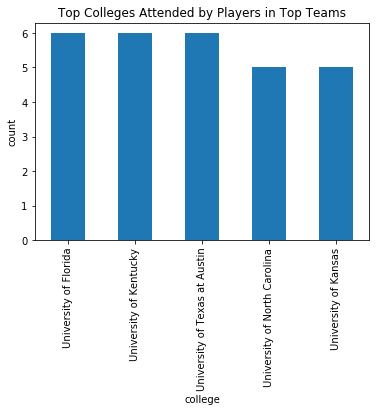

In [156]:
players_in_top_teams = playerinfo[playerinfo['teamAbbr'].isin(np.array(tophalf.index))]
topcolleges = players_in_top_teams.groupby('college').size().sort_values(ascending = False).head(5)
topcolleges.plot(kind = 'bar', x = 'college')
plt.ylabel('count')
plt.title('Top Colleges Attended by Players in Top Teams');

We also looked at the distribution of games played to see if successful teams necessarily had more veteran players, or if novice players also had a good chance of being on some of the top teams. We looked at NCAA games only, because we wannted to focus on how many games the players played before they were signed onto an NBA team. 

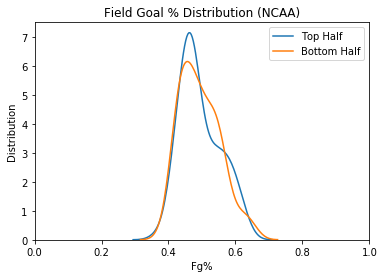

In [157]:
players_in_bottom_teams = playerinfo[~playerinfo['teamAbbr'].isin(np.array(tophalf.index))]
topteamsncaa = players_in_top_teams['NCAA_fg%']
bottomteamsncaa = players_in_bottom_teams['NCAA_fg%']

sns.distplot(topteamsncaa, hist = False, label = 'Top Half')
sns.distplot(bottomteamsncaa, hist = False, label = 'Bottom Half')
plt.xlabel('Fg%')
plt.ylabel('Distribution')
plt.title('Field Goal % Distribution (NCAA)')
plt.xlim(0, 1);

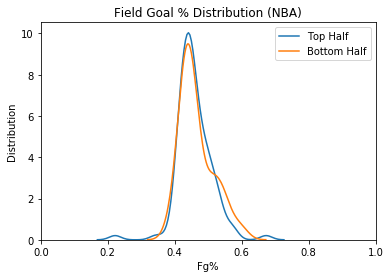

In [158]:
topteamsnba = players_in_top_teams['NBA_fg%']
bottomteamsnba = players_in_bottom_teams['NBA_fg%']

sns.distplot(topteamsnba, hist = False, label = 'Top Half')
sns.distplot(bottomteamsnba, hist = False, label = 'Bottom Half')
plt.xlabel('Fg%')
plt.ylabel('Distribution')
plt.title('Field Goal % Distribution (NBA)')
plt.xlim(0, 1);

### Game Information

Besides the players, the top teams probably have some type of strategy or gameplay they follow that helps them be successful. Although we aren't able to access the specific details of their game strategy, we can analyze information from the games themselves to see if there are any common patterns.

In [289]:
# Standardizing the data from games in the 2016-17 NBA season into the games1617 dataframe
games1617 = team_box_score[team_box_score["gmDate"]>='2016-10-25']
games1617 = games1617[games1617["gmDate"]<='2017-04-12']
games1617 = games1617.groupby("teamAbbr").mean()
games1617 = (games1617 - np.mean(games1617, axis=0)) / np.std((games1617 - np.mean(games1617, axis=0)), axis=0)
games1617.reset_index(inplace=True)

# Finding which teams made it to the 2016-17 NBA season playoffs and adding that as the column 'playoff_teams' in games1617
# 1 represents making it to the playoffs and 0 represents not making it to the playoffs
standings1617 = final_season_standings[final_season_standings['stDate'] == '2017-04-12']
playoffs1617 = standings1617.sort_values("rank").iloc[:16]["teamAbbr"].values
playoffs1617 = np.where(games1617['teamAbbr'].isin(playoffs1617), 1, 0)
games1617["playoff_teams"] = playoffs1617
games1617

,teamAbbr,teamMin,teamDayOff,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,...,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace,playoff_teams
0,ATL,1.266926,-1.351646,-0.598638,0.462783,1.448412,0.710008,0.152885,-1.069256,-0.463427,...,-1.251025,-1.210096,0.225087,-1.415774,0.287552,-0.573147,0.526632,0.568309,0.441889,1
1,BKN,-0.998438,0.735454,0.043617,-0.556497,2.041254,-0.713805,-0.094083,0.716637,-0.081086,...,0.774135,-1.470029,1.548193,0.807829,-0.450388,0.397904,2.439332,1.992941,2.091817,0
2,BOS,-0.804818,-0.457174,0.595837,1.196442,-0.543924,-0.277169,-0.905547,0.412655,-0.142039,...,-0.131797,0.727967,-0.626878,-0.255481,-0.141833,-0.106672,-0.238523,0.045997,0.137007,1
3,CHA,0.337546,-0.755331,-0.172469,0.199562,-1.982294,-1.188409,0.135244,-2.064797,-0.009051,...,-0.097560,0.003349,-0.056763,-0.164069,1.575318,1.480089,-0.749021,-0.264945,-0.304390,0
4,CHI,-0.591835,-0.755331,-0.670666,-0.024455,-0.339831,0.273372,0.188166,-1.342840,0.761172,...,-0.730603,-0.436945,-0.073703,0.234672,0.871485,0.924406,-0.269040,-0.555274,-0.494026,1
5,CLE,1.325012,-0.159017,1.169064,0.014748,-0.223206,-1.719965,-1.046671,-1.099655,-0.208533,...,0.631045,1.455072,-0.755932,1.068524,1.252804,2.213217,0.673578,0.033325,-0.105935,1
6,DAL,-0.746731,-0.755331,-1.889150,-0.842120,-1.671295,-0.334121,-1.487685,-0.491691,-1.416508,...,-0.035817,-0.956658,0.707657,-0.214417,-0.158729,-1.226045,-2.119302,-1.873218,-1.786407,0
7,DEN,-1.095249,1.033611,1.508199,1.241245,0.777821,-1.169424,-1.134874,-0.491691,1.060395,...,1.683226,1.371869,-0.107937,2.254918,0.887344,2.182453,2.272117,0.681225,0.788095,0
8,DET,-0.262679,1.629926,-1.048817,-0.685308,-1.671295,-1.093488,-1.399482,-1.251646,1.542477,...,-0.661314,-0.897407,0.314993,-0.182963,1.205822,1.643723,0.133669,-0.604702,-0.572340,0
9,GS,-0.630559,1.928083,2.534607,3.559829,0.661196,2.912171,2.887167,-0.354899,0.766713,...,-2.031225,2.057748,-2.693757,-1.838543,-0.617339,-1.127595,-0.038176,1.388144,1.447291,1


opptFIC      0.536464
opptPTS1     0.537117
opptFIC40    0.542607
opptEFG%     0.543521
teamPPS      0.550826
teamOrtg     0.554917
opptDrtg     0.554917
opptFG%      0.560538
teamEDiff    0.707122
opptEDiff    0.707122
Name: playoff_teams, dtype: float64


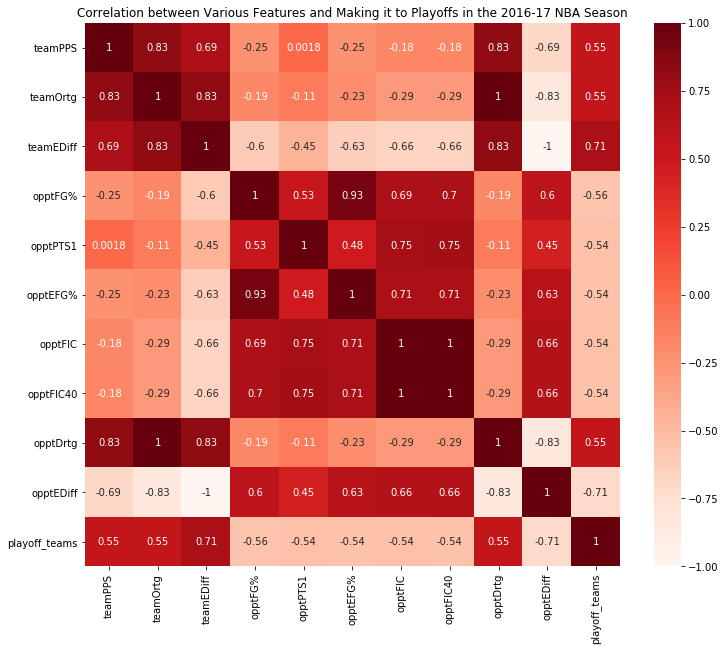

In [287]:
# Correlating the features in games1617 against the 'playoff_teams' column
cor = games1617.corr()
output_var = abs(cor["playoff_teams"])

# Finding the most correlated features in the 2016-17 NBA season of making it to playoffs
relevant_features = output_var[output_var>=0.535].drop("playoff_teams")

print(relevant_features.sort_values())

reldf = games1617[output_var[output_var>=0.535].index]
plt.figure(figsize=(12,10))
sns.heatmap(reldf.corr(), annot=True, cmap=plt.cm.Reds)
plt.title('Correlation between Various Features and Making it to Playoffs in the 2016-17 NBA Season')
plt.show();

In [278]:
# Get the teams that make playoffs for each season

games1213 = team_box_score[team_box_score["gmDate"]<='2013-04-17']
games1213 = games1213.groupby("teamAbbr").mean().reset_index()
#games1213 = (games1213 - np.mean(games1213, axis=0)) / np.std((games1213 - np.mean(games1213, axis=0)), axis=0)
#games1213.reset_index(inplace=True)
standings1213 = final_season_standings[final_season_standings['stDate'] == '2013-04-17']
playoffs1213 = standings1213.sort_values("rank").iloc[:16]["teamAbbr"].values
playoffs1213 = np.where(games1213['teamAbbr'].isin(playoffs1213), 1, 0)

games1314 = team_box_score[team_box_score["gmDate"]>'2013-04-17']
games1314 = games1314[games1314["gmDate"]<='2014-04-16']
games1314 = games1314.groupby("teamAbbr").mean().reset_index()
#games1314 = (games1314 - np.mean(games1314, axis=0)) / np.std((games1314 - np.mean(games1314, axis=0)), axis=0)
#games1314.reset_index(inplace=True)
standings1314 = final_season_standings[final_season_standings['stDate'] == '2014-04-16']
playoffs1314 = standings1314.sort_values("rank").iloc[:16]["teamAbbr"].values
playoffs1314 = np.where(games1314['teamAbbr'].isin(playoffs1314), 1, 0)

games1415 = team_box_score[team_box_score["gmDate"]>'2014-04-16']
games1415 = games1415[games1415["gmDate"]<='2015-04-15']
games1415 = games1415.groupby("teamAbbr").mean().reset_index()
#games1415 = (games1415 - np.mean(games1415, axis=0)) / np.std((games1415 - np.mean(games1415, axis=0)), axis=0)
#games1415.reset_index(inplace=True)
standings1415 = final_season_standings[final_season_standings['stDate'] == '2015-04-15']
playoffs1415 = standings1415.sort_values("rank").iloc[:16]["teamAbbr"].values
playoffs1415 = np.where(games1415['teamAbbr'].isin(playoffs1415), 1, 0)

games1516 = team_box_score[team_box_score["gmDate"]>'2015-04-15']
games1516 = games1516[games1516["gmDate"]<='2016-04-13']
games1516 = games1516.groupby("teamAbbr").mean().reset_index()
#games1516 = (games1516 - np.mean(games1516, axis=0)) / np.std((games1516 - np.mean(games1516, axis=0)), axis=0)
#games1516.reset_index(inplace=True)
standings1516 = final_season_standings[final_season_standings['stDate'] == '2016-04-13']
playoffs1516 = standings1516.sort_values("rank").iloc[:16]["teamAbbr"].values
playoffs1516 = np.where(games1516['teamAbbr'].isin(playoffs1516), 1, 0)

#games1617 = team_box_score[team_box_score["gmDate"]>='2016-10-25']
#games1617 = games1617[games1617["gmDate"]<='2017-04-12']
#games1617 = games1617.groupby("teamAbbr").mean().reset_index()
#df = final_season_standings[final_season_standings['stDate'] == '2017-04-12']
#playoffs1617 = df.sort_values("rank").iloc[:16]["teamAbbr"].values
#playoffs1617 = np.where(games1617['teamAbbr'].isin(playoffs1617), 1, 0)

games1718 = team_box_score[team_box_score["gmDate"]>='2017-10-17']
games1718 = games1718.groupby("teamAbbr").mean().reset_index()
#games1718 = (games1718 - np.mean(games1718, axis=0)) / np.std((games1718 - np.mean(games1718, axis=0)), axis=0)
#games1718.reset_index(inplace=True)
standings1718 = final_season_standings[final_season_standings['stDate'] == '2018-04-11']
playoffs1718 = standings1718.sort_values("rank").iloc[:16]["teamAbbr"].values
playoffs1718 = np.where(games1718['teamAbbr'].isin(playoffs1718), 1, 0)

## Part 2: What Factors Cause Teams to go to the Playoffs?

Now that we know a little bit more about what factors cause teams to be successful, we wanted to build a model that predicts what teams go to the championships. 

In [279]:
# Getting a list of the features that most correlate with making it to playoffs
rel_cols = relevant_features.index

# Standardizing the data of the relevant features for each season
from sklearn import preprocessing
games1213scaled = preprocessing.scale(games1213[rel_cols])
games1314scaled = preprocessing.scale(games1314[rel_cols])
games1415scaled = preprocessing.scale(games1415[rel_cols])
games1516scaled = preprocessing.scale(games1516[rel_cols])
games1617scaled = preprocessing.scale(games1617[rel_cols])
games1718scaled = preprocessing.scale(games1718[rel_cols])

In [291]:
# Method to determine whether a prediction was successful or not
# If prediction and actual result are both 0, that means the team didn't make it to playoffs and that's what was predicted
# If prediction and actual result are both 1, that means the team made it to playoffs and that's waht was predicted
# If prediction was 1 and actual result was 0, that means the team didn't make it to playoffs but it was predicted that they would
# If prediction was 0 and actual result was 1, that emans the team made it to playoffs but it was predicted that they wouldn't

def conditional(s):
    if s["playoffs predictions"]==0 and s["went to playoffs"]==0:
        return "Didn't make playoffs, sucessful prediction"
    elif s["playoffs predictions"]==1 and s["went to playoffs"]==1:
        return "Made playoffs, sucessful prediction"
    elif s["playoffs predictions"]==1 and s["went to playoffs"]==0:
        return "Didn't make playoffs, failed prediction"
    else:
        return "Made playoffs, failed prediction"

We first created a logistic regression model for our data. We used the features based on our correlation heatmap to predict if a team would make playoffs or not. A value of 1 represents the team making the playoffs, while a value of 0 represents the team not making the playoffs. We used the data from 2012-2016 to train our model, and tested our model on 2017-2018 data.

In [283]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(games1213scaled, playoffs1213)
lr_model.fit(games1314scaled, playoffs1314)
lr_model.fit(games1415scaled, playoffs1415)
lr_model.fit(games1516scaled, playoffs1516)
lr_model.fit(games1617scaled, playoffs1617)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Logisitical Regression Training Accuracy:  0.9666666666666667
Logistical Regression Test Accuracy:  0.9666666666666667


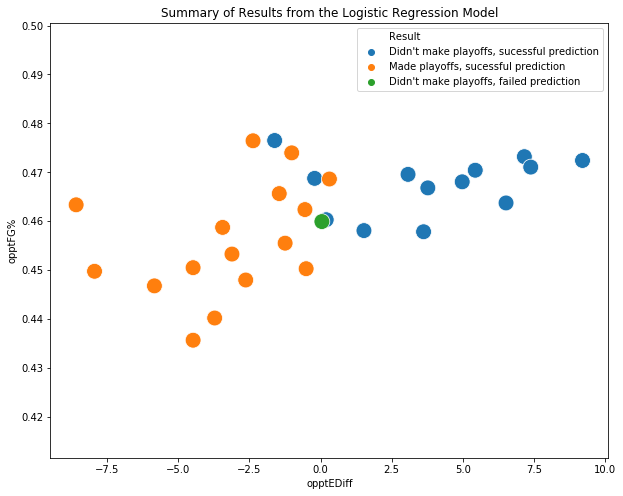

In [284]:
lr_training_accuracy = lr_model.score(games1617scaled, playoffs1617)
lr_test_accuracy = lr_model.score(games1718scaled, playoffs1718)
print("Logisitical Regression Training Accuracy: ", lr_training_accuracy)
print("Logistical Regression Test Accuracy: ", lr_test_accuracy)
lr_results = pd.DataFrame(data={'team': games1718['teamAbbr'], 'playoffs predictions': lr_model.predict(games1718scaled), 'went to playoffs': playoffs1718})

prediction_data = lr_results.join(games1718)
prediction_data["Result"] = prediction_data.apply(conditional, axis=1)
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x='opptEDiff', y='opptFG%', hue='Result', data=prediction_data, s=250)
plt.title("Summary of Results from the Logistic Regression Model")
plt.show();

We also wanted to use a different model so that we could validate our feature selection and ensure that our features were good indicators of whether the teams would make it to playoffs. We used the same years to train and test our model.

In [285]:
from sklearn import tree
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(games1213scaled, playoffs1213)
dt_model.fit(games1314scaled, playoffs1314)
dt_model.fit(games1415scaled, playoffs1415)
dt_model.fit(games1516scaled, playoffs1516)
dt_model.fit(games1617scaled, playoffs1617)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Decision Tree Training Accuracy:  1.0
Decision Tree Test Accuracy:  0.8


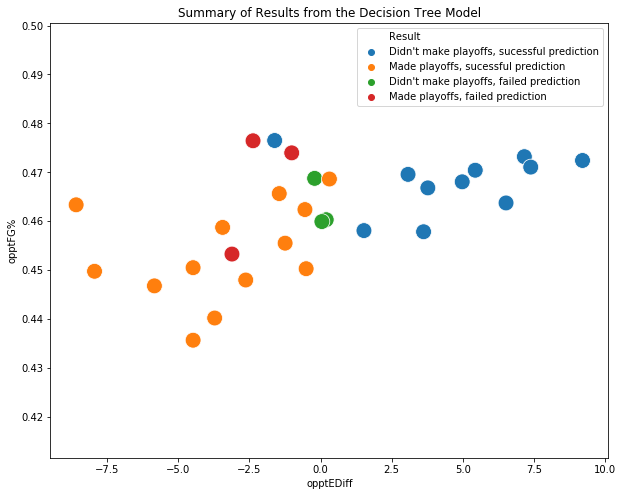

In [288]:
dt_training_accuracy = dt_model.score(games1617scaled, playoffs1617)
dt_test_accuracy = dt_model.score(games1718scaled, playoffs1718)
print("Decision Tree Training Accuracy: ", dt_training_accuracy)
print("Decision Tree Test Accuracy: ", dt_test_accuracy)
dt_results = pd.DataFrame(data={'team': games1718['teamAbbr'], 'playoffs predictions': dt_model.predict(games1718scaled), 'went to playoffs': playoffs1718})

prediction_data = dt_results.join(games1718)
prediction_data["Result"] = prediction_data.apply(conditional, axis=1)
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x='opptEDiff', y='opptFG%', hue='Result', data=prediction_data, s=250)
plt.title("Summary of Results from the Decision Tree Model")
plt.show();